# Kannusteet

In [1]:
# haetaan tarpeelliset kirjastot
import fin_benefits 

## Tyyppitapauksia ja niiden korvausasteita

Seuraava koodi laskee työnteon efektiivisen marginaaliveron, eli sen, paljonko ansaitusta lisäsatasesta menee eri tulotasoilla veroa.

In [2]:
# laitetaan mallin parametrit muuttujaan p
p={}
p['tyoton']=1
p['ika']=30
p['saa_ansiopaivarahaa']=0
p['piikit_pois']=0
p['t']=0
p['vakiintunutpalkka']=2500
p['elakkeella']=0
p['asumismenot_toimeentulo']=500
p['asumismenot_asumistuki']=500
p['lapsia']=0
p['paivahoidossa']=0
p['aikuisia']=1
p['veromalli']=0
p['kuntaryhma']=3
p['lapsia_kotihoidontuella']=0
p['alle3v']=0
p['ansiopvrahan_suojaosa']=1
p['ansiopvraha_lapsikorotus']=1
p['puolison_tulot']=0
p['puoliso_tyoton']=0  
p['puoliso_vakiintunutpalkka']=0  
p['puoliso_saa_ansiopaivarahaa']=0
p['puolison_tulot']=0


Yllä määritellään parametrit. Itse laskenta koostuu kahdesta rivistä koodia.

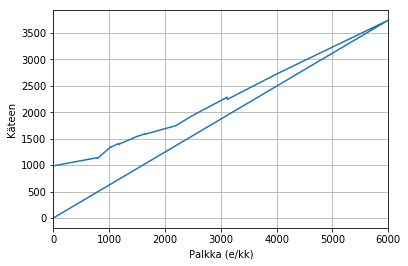

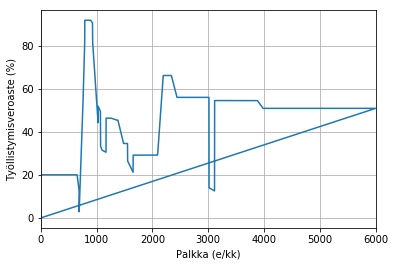

In [3]:
# Luokka Benefits() sisältää koodin
ben=fin_benefits.Benefits()

# ja lasketaan & plotataan tulokset
ben.laske_ja_plottaa(p)